# Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision.models import vgg11
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

/root/miniconda3/envs/torch2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:1


# Dataset Loader

In [3]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

def data_loader(batch_size, num_workers=0, random_seed=42, valid_size=0.1, shuffle=True, test=False):

    # Define augmentations
    transform_augmented2 = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2470, 0.2435, 0.2616],
        )
    ])

    transform_augmented1 = transforms.Compose([
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2470, 0.2435, 0.2616],
        )
    ])

    transform_augmented_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2470, 0.2435, 0.2616],
        )
    ])

    # Download CIFAR-10 dataset
    if test:
        dataset = datasets.CIFAR10(
            root='./data', train=False,
            download=True, transform=transform_augmented_test,
        )

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers
        )

        return data_loader

    # Load the dataset
    train_dataset = datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_augmented1)
    train_dataset2 = datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_augmented2)

    valid_dataset = datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_augmented1)
    valid_dataset2 = datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_augmented2)


    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # Save 10% of training data in a new variable train_loader_SI
    train_si_sampler = SubsetRandomSampler(indices[:int(0.1 * num_train)])
    train_loader_SI = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_si_sampler, num_workers=num_workers)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
    
    ######
    # Save 10% of training data in a new variable train_loader_SI2
    train_si_sampler2 = SubsetRandomSampler(indices[:int(0.1 * num_train)])
    train_loader_SI2 = torch.utils.data.DataLoader(
        train_dataset2, batch_size=batch_size, sampler=train_si_sampler2, num_workers=num_workers)

    train_loader2 = torch.utils.data.DataLoader(
        train_dataset2, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)

    valid_loader2 = torch.utils.data.DataLoader(
        valid_dataset2, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)

    return (train_loader, valid_loader, train_loader_SI, train_loader2, valid_loader2, train_loader_SI2)

# Example usage
train_loader, valid_loader, train_loader_SI, train_loader2, valid_loader2, train_loader_SI2 = data_loader(batch_size=128, num_workers=1)
test_loader = data_loader(batch_size=128, test=True, num_workers=1)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Functions

In [4]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda'):
    # Define criterion, optimizer, and learning rate scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=5e-4, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    # Initialize variables for tracking best accuracy and corresponding model weights
    best_val_acc = 0.0
    best_model_weights = None
    early_stopping_counter = 0

    # Lists to store metrics
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    total_step = len(train_loader)

    for epoch in tqdm(range(num_epochs)):
        model.train()
        correct_train = 0
        total_train = 0
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            running_loss += loss.item()

        # Calculate and store training accuracy and loss
        epoch_train_accuracy = 100 * correct_train / total_train
        epoch_train_loss = running_loss / len(train_loader)
        train_acc_list.append(epoch_train_accuracy)
        train_loss_list.append(epoch_train_loss)

        # Step the learning rate scheduler
        scheduler.step()

        # Validation
        with torch.no_grad():
            model.eval()
            correct = 0
            total = 0
            val_loss = 0

            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item()

            # Calculate validation accuracy
            current_val_acc = 100 * correct / total

            # Store validation loss and accuracy
            val_loss_list.append(val_loss / len(valid_loader))
            val_acc_list.append(current_val_acc)

            # Check if the current accuracy is the best so far
            if current_val_acc > best_val_acc:
                best_val_acc = current_val_acc
                # Save the model weights
                best_model_weights = model.state_dict()
                # Reset early stopping counter
                early_stopping_counter = 0
            else:
                # Increment early stopping counter
                early_stopping_counter += 1

            # Check for early stopping
            if early_stopping_counter >= early_stopping_threshold:
                print(f'Early stopping after {early_stopping_counter} epochs without improvement.')
                break

        # Print and save metrics
        print('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%, Validation Loss: {:.4f}'
              .format(epoch + 1, num_epochs, i + 1, total_step, epoch_train_loss, epoch_train_accuracy, current_val_acc, val_loss_list[-1]))

    # Print test set accuracy on the best weights
    test_accuracy = test_model(model, test_loader, device)
    print(f'Test Set Accuracy on Best Weights: {test_accuracy:.2f}%')

    # Save the model with the best validation accuracy
    torch.save(best_model_weights, 'best_model_weights.pth')

    # Plot training and validation metrics
    plot_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list)

def test_model(model, test_loader, device='cuda'):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    return test_accuracy

def plot_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list):
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_list, label='Training Accuracy')
    plt.plot(val_acc_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [5]:
# Print the summary with information about frozen layers
def print_trainable_status(module, prefix=""):
    for name, child in module.named_children():
        for param in child.parameters():
            print(f"{prefix}{'.'.join([module._get_name(), name])}: requires_grad={param.requires_grad}")
        print_trainable_status(child, prefix + "  ")

In [3]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

Cloning into 'data_complexity_measures'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 143 (delta 82), reused 33 (delta 9), pack-reused 0
Receiving objects: 100% (143/143), 144.63 KiB | 767.00 KiB/s, done.
Resolving deltas: 100% (82/82), done.


In [4]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm
from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex

# First Layer

In [9]:
import torch.nn as nn

class VGG_first_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG_first_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(64 * 16 * 16, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create model
model = VGG_first_layer()

# Move the model to the specified device
model.to(device)

VGG_first_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=16384, out_features=512, bias=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)

  7%|▋         | 1/15 [00:21<05:00, 21.46s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.6472, Training Accuracy: 42.39%, Validation Accuracy: 48.92%, Validation Loss: 1.4207


 13%|█▎        | 2/15 [00:46<05:06, 23.55s/it]

Epoch [2/15], Step [352/352], Training Loss: 1.3510, Training Accuracy: 52.02%, Validation Accuracy: 54.14%, Validation Loss: 1.2745


 20%|██        | 3/15 [01:08<04:35, 22.98s/it]

Epoch [3/15], Step [352/352], Training Loss: 1.2415, Training Accuracy: 56.10%, Validation Accuracy: 56.02%, Validation Loss: 1.2611


 27%|██▋       | 4/15 [01:30<04:05, 22.29s/it]

Epoch [4/15], Step [352/352], Training Loss: 1.1813, Training Accuracy: 58.36%, Validation Accuracy: 60.22%, Validation Loss: 1.1382


 33%|███▎      | 5/15 [01:51<03:38, 21.83s/it]

Epoch [5/15], Step [352/352], Training Loss: 1.1355, Training Accuracy: 60.23%, Validation Accuracy: 56.10%, Validation Loss: 1.2830


 40%|████      | 6/15 [02:13<03:17, 21.94s/it]

Epoch [6/15], Step [352/352], Training Loss: 1.0030, Training Accuracy: 65.32%, Validation Accuracy: 64.02%, Validation Loss: 1.0384


 47%|████▋     | 7/15 [02:34<02:53, 21.73s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.9758, Training Accuracy: 66.09%, Validation Accuracy: 63.66%, Validation Loss: 1.0454


 53%|█████▎    | 8/15 [02:56<02:32, 21.83s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.9635, Training Accuracy: 66.55%, Validation Accuracy: 64.62%, Validation Loss: 1.0256


 60%|██████    | 9/15 [03:18<02:10, 21.82s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.9566, Training Accuracy: 66.92%, Validation Accuracy: 64.12%, Validation Loss: 1.0383


 67%|██████▋   | 10/15 [03:39<01:47, 21.51s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.9475, Training Accuracy: 67.22%, Validation Accuracy: 64.30%, Validation Loss: 1.0086


 73%|███████▎  | 11/15 [04:01<01:26, 21.67s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.9307, Training Accuracy: 68.06%, Validation Accuracy: 64.00%, Validation Loss: 1.0190


 80%|████████  | 12/15 [04:23<01:05, 21.72s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.9263, Training Accuracy: 67.79%, Validation Accuracy: 65.70%, Validation Loss: 1.0064


 87%|████████▋ | 13/15 [04:44<00:43, 21.63s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.9252, Training Accuracy: 67.90%, Validation Accuracy: 64.46%, Validation Loss: 1.0233


 93%|█████████▎| 14/15 [05:06<00:21, 21.83s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.9251, Training Accuracy: 68.08%, Validation Accuracy: 64.76%, Validation Loss: 1.0121


100%|██████████| 15/15 [05:28<00:00, 21.93s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.9248, Training Accuracy: 68.11%, Validation Accuracy: 64.58%, Validation Loss: 1.0016


Test Set Accuracy on Best Weights: 66.62%


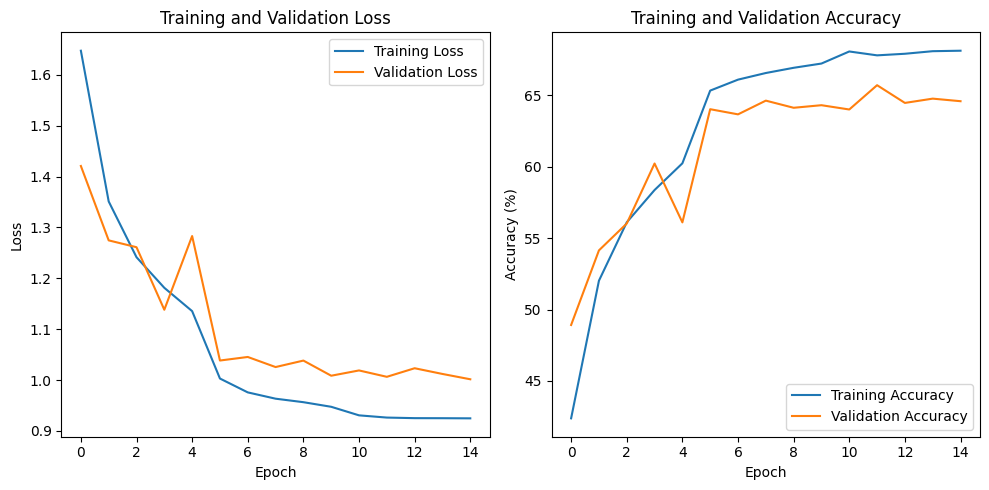

In [7]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0')

# Center SI first layer - train

In [7]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG_first_layer().to(device)
model.load_state_dict(torch.load('first_layer_ve.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()
# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))
        
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)     

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))
    
        

100%|██████████| 40/40 [00:01<00:00, 36.35it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 382.24it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2864.31it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3179.91it/s]


[('layer1', 0.4023999869823456), ('fc1', 0.6259999871253967), ('fc2', 0.5852000117301941)]


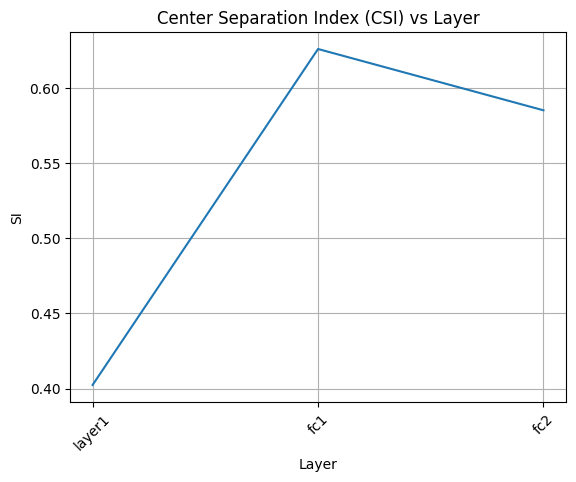

In [8]:
print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Center SI first layer - test

100%|██████████| 79/79 [00:01<00:00, 47.36it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2767.06it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4223.02it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4445.94it/s]

[('layer1', 0.4001999795436859), ('fc1', 0.6507999897003174), ('fc2', 0.5990999937057495)]


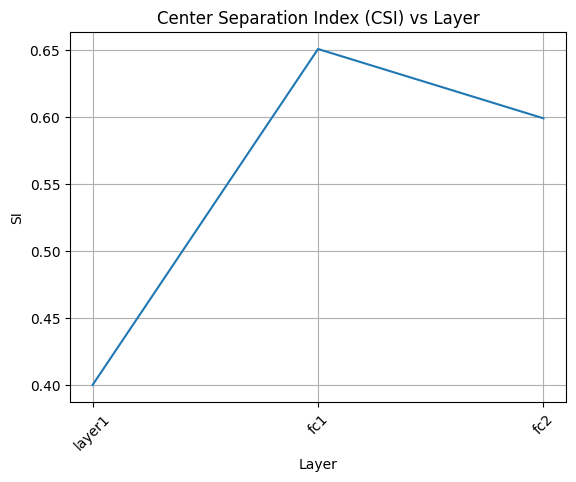

In [10]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG_first_layer().to(device)
model.load_state_dict(torch.load('first_layer_ve.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()
# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))
        
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)     

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))
    
print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()       

# Second Layer

In [11]:
import torch.nn as nn

class VGG11_second_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_second_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(8192, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


# Initialize your model
model = VGG11_second_layer().to(device)

model

VGG11_second_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=8192, out_features=512, bias=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)

  7%|▋         | 1/15 [00:22<05:17, 22.70s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.4136, Training Accuracy: 49.25%, Validation Accuracy: 54.76%, Validation Loss: 1.2923


 13%|█▎        | 2/15 [00:44<04:47, 22.12s/it]

Epoch [2/15], Step [352/352], Training Loss: 1.1363, Training Accuracy: 59.57%, Validation Accuracy: 61.32%, Validation Loss: 1.1090


 20%|██        | 3/15 [01:05<04:21, 21.79s/it]

Epoch [3/15], Step [352/352], Training Loss: 1.0350, Training Accuracy: 63.36%, Validation Accuracy: 62.98%, Validation Loss: 1.0767


 27%|██▋       | 4/15 [01:28<04:01, 21.98s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.9632, Training Accuracy: 66.15%, Validation Accuracy: 63.86%, Validation Loss: 1.0408


 33%|███▎      | 5/15 [01:50<03:42, 22.22s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.8989, Training Accuracy: 68.66%, Validation Accuracy: 66.96%, Validation Loss: 0.9216


 40%|████      | 6/15 [02:12<03:17, 21.90s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.7622, Training Accuracy: 73.68%, Validation Accuracy: 70.64%, Validation Loss: 0.8206


 47%|████▋     | 7/15 [02:34<02:56, 22.02s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.7426, Training Accuracy: 74.20%, Validation Accuracy: 71.58%, Validation Loss: 0.8160


 53%|█████▎    | 8/15 [02:56<02:34, 22.05s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.7300, Training Accuracy: 74.86%, Validation Accuracy: 71.70%, Validation Loss: 0.7974


 60%|██████    | 9/15 [03:17<02:10, 21.72s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.7169, Training Accuracy: 75.28%, Validation Accuracy: 71.12%, Validation Loss: 0.8073


 67%|██████▋   | 10/15 [03:41<01:51, 22.36s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.7084, Training Accuracy: 75.71%, Validation Accuracy: 71.54%, Validation Loss: 0.8038


 73%|███████▎  | 11/15 [04:03<01:28, 22.24s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.6873, Training Accuracy: 76.37%, Validation Accuracy: 72.58%, Validation Loss: 0.7931


 80%|████████  | 12/15 [04:24<01:05, 21.97s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.6828, Training Accuracy: 76.69%, Validation Accuracy: 72.42%, Validation Loss: 0.7728


 87%|████████▋ | 13/15 [04:46<00:43, 21.99s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.6863, Training Accuracy: 76.28%, Validation Accuracy: 71.92%, Validation Loss: 0.7897


 93%|█████████▎| 14/15 [05:08<00:22, 22.06s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.6825, Training Accuracy: 76.48%, Validation Accuracy: 72.70%, Validation Loss: 0.7815


100%|██████████| 15/15 [05:29<00:00, 22.00s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.6811, Training Accuracy: 76.58%, Validation Accuracy: 72.64%, Validation Loss: 0.7931


Test Set Accuracy on Best Weights: 74.83%


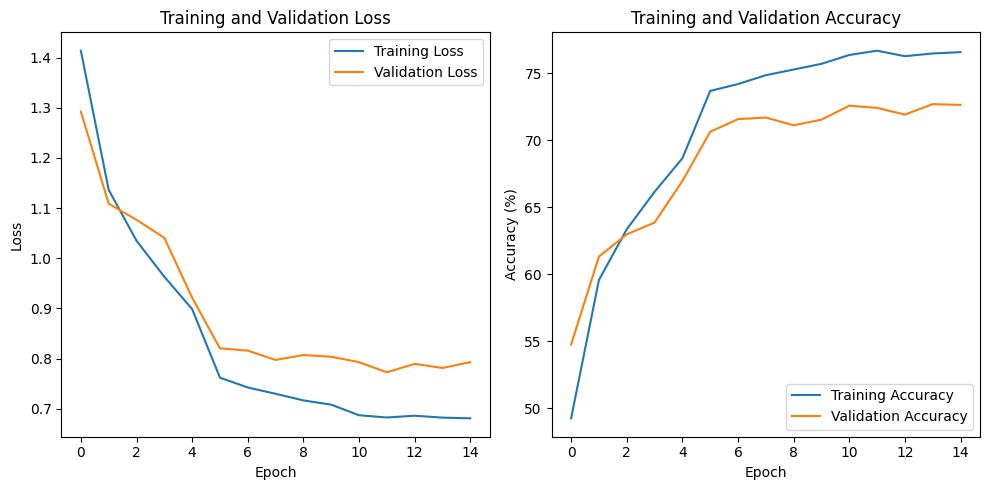

In [9]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0')

# Center SI second layer - train

100%|██████████| 40/40 [00:01<00:00, 35.07it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2013.91it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2988.82it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3264.90it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3065.26it/s]

[('layer1', 0.4113999903202057), ('layer2', 0.49939998984336853), ('fc1', 0.7062000036239624), ('fc2', 0.6697999835014343)]


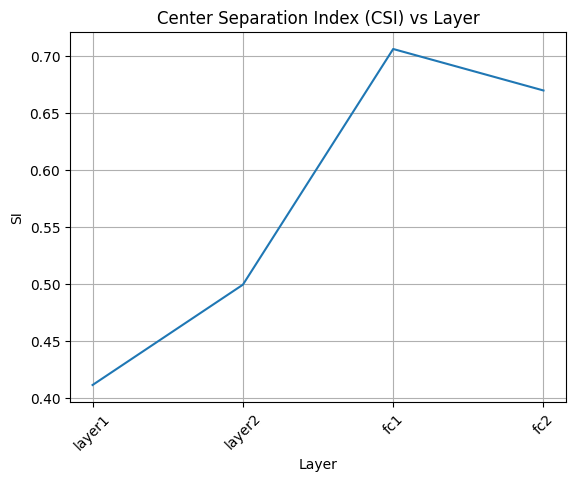

[('layer1', 0.4113999903202057), ('layer2', 0.49939998984336853), ('fc1', 0.7062000036239624), ('fc2', 0.6697999835014343)]


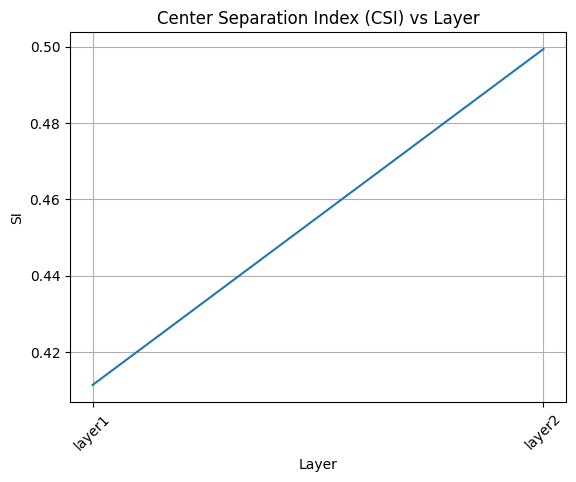

In [12]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_second_layer().to(device)
model.load_state_dict(torch.load('second_layer_ve.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Center SI second layer - test

100%|██████████| 79/79 [00:01<00:00, 55.21it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2873.60it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4285.15it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4381.85it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4349.13it/s]

[('layer1', 0.4113999903202057), ('layer2', 0.5072000026702881), ('fc1', 0.7267000079154968), ('fc2', 0.6820999979972839)]


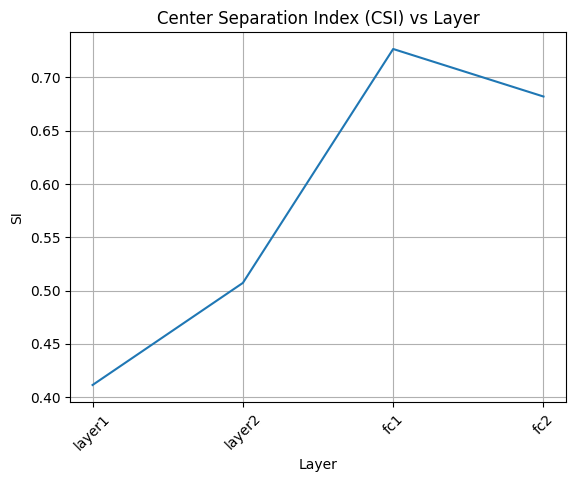

[('layer1', 0.4113999903202057), ('layer2', 0.5072000026702881), ('fc1', 0.7267000079154968), ('fc2', 0.6820999979972839)]


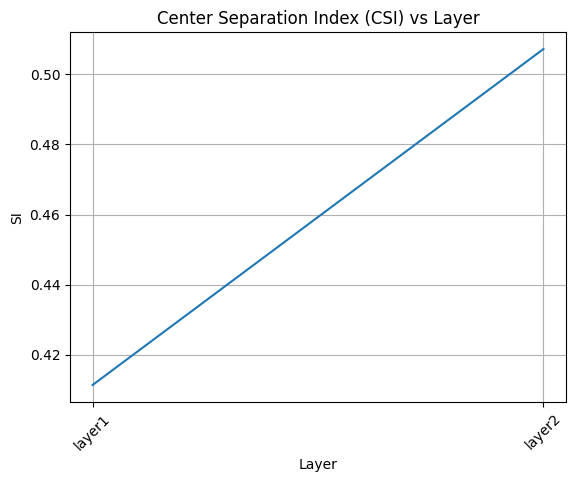

In [13]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_second_layer().to(device)
model.load_state_dict(torch.load('second_layer_ve.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Third Layer

In [14]:
import torch.nn as nn

class VGG11_third_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_third_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [15]:
model = VGG11_third_layer().to(device)
model

VGG11_third_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc1): Sequential(
    (0): Linear(in_features=16384, out_features=512, bias=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)

  7%|▋         | 1/15 [00:25<05:52, 25.18s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.3005, Training Accuracy: 53.46%, Validation Accuracy: 58.28%, Validation Loss: 1.2112


 13%|█▎        | 2/15 [00:47<05:07, 23.66s/it]

Epoch [2/15], Step [352/352], Training Loss: 0.9911, Training Accuracy: 65.06%, Validation Accuracy: 60.46%, Validation Loss: 1.0982


 20%|██        | 3/15 [01:10<04:36, 23.01s/it]

Epoch [3/15], Step [352/352], Training Loss: 0.8694, Training Accuracy: 69.37%, Validation Accuracy: 67.28%, Validation Loss: 0.9087


 27%|██▋       | 4/15 [01:33<04:13, 23.01s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.7817, Training Accuracy: 72.52%, Validation Accuracy: 68.60%, Validation Loss: 0.8905


 33%|███▎      | 5/15 [01:55<03:49, 22.91s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.7229, Training Accuracy: 74.63%, Validation Accuracy: 73.44%, Validation Loss: 0.7605


 40%|████      | 6/15 [02:17<03:24, 22.68s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.5363, Training Accuracy: 81.52%, Validation Accuracy: 77.14%, Validation Loss: 0.6758


 47%|████▋     | 7/15 [02:41<03:02, 22.82s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.4987, Training Accuracy: 82.76%, Validation Accuracy: 77.72%, Validation Loss: 0.6487


 53%|█████▎    | 8/15 [03:04<02:40, 22.91s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.4759, Training Accuracy: 83.46%, Validation Accuracy: 78.14%, Validation Loss: 0.6520


 60%|██████    | 9/15 [03:27<02:17, 22.94s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.4631, Training Accuracy: 84.01%, Validation Accuracy: 77.90%, Validation Loss: 0.6404


 67%|██████▋   | 10/15 [03:49<01:53, 22.66s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.4460, Training Accuracy: 84.56%, Validation Accuracy: 78.80%, Validation Loss: 0.6262


 73%|███████▎  | 11/15 [04:12<01:31, 22.81s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.4187, Training Accuracy: 85.57%, Validation Accuracy: 78.86%, Validation Loss: 0.6229


 80%|████████  | 12/15 [04:35<01:08, 22.89s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.4156, Training Accuracy: 85.75%, Validation Accuracy: 79.38%, Validation Loss: 0.6207


 87%|████████▋ | 13/15 [04:57<00:45, 22.74s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.4131, Training Accuracy: 86.04%, Validation Accuracy: 79.14%, Validation Loss: 0.6037


 93%|█████████▎| 14/15 [05:20<00:22, 22.61s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.4133, Training Accuracy: 85.86%, Validation Accuracy: 79.32%, Validation Loss: 0.6370


100%|██████████| 15/15 [05:43<00:00, 22.89s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.4112, Training Accuracy: 85.90%, Validation Accuracy: 79.18%, Validation Loss: 0.6081


Test Set Accuracy on Best Weights: 80.15%


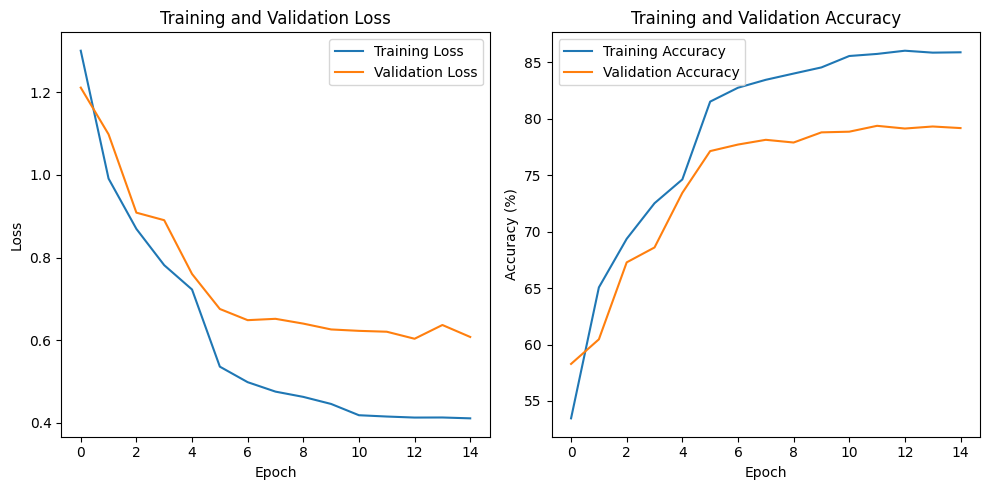

In [12]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0')

# Center SI third layer - train

100%|██████████| 40/40 [00:00<00:00, 43.00it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1943.01it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2983.15it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2072.97it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3218.96it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3001.65it/s]


[('layer1', 0.4057999849319458), ('layer2', 0.5059999823570251), ('layer3', 0.6121999621391296), ('fc1', 0.7755999565124512), ('fc2', 0.7421999573707581)]


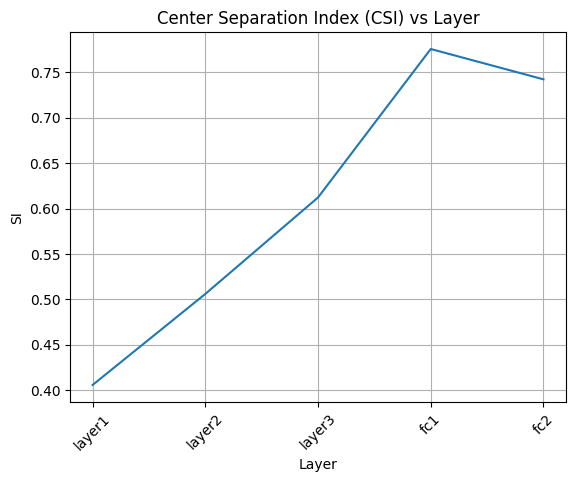

In [16]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_third_layer().to(device)
model.load_state_dict(torch.load('third_layer_ve.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.4057999849319458), ('layer2', 0.5059999823570251), ('layer3', 0.6121999621391296), ('fc1', 0.7755999565124512), ('fc2', 0.7421999573707581)]


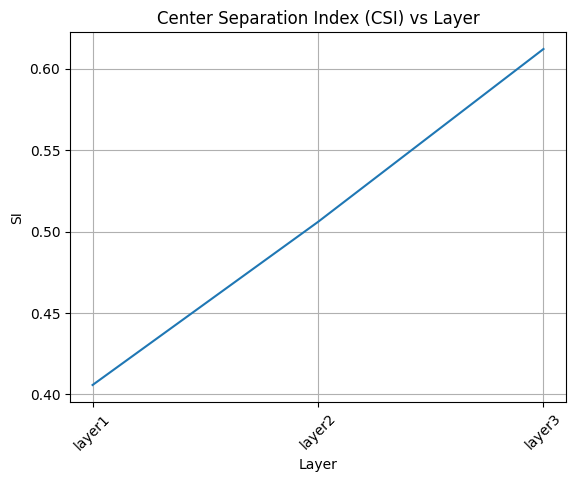

In [17]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Center SI third layer - test

100%|██████████| 79/79 [00:01<00:00, 58.80it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2929.80it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4196.82it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2759.41it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4292.17it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4233.25it/s]


[('layer1', 0.40459999442100525), ('layer2', 0.5181999802589417), ('layer3', 0.614799976348877), ('fc1', 0.7827999591827393), ('fc2', 0.7473999857902527)]


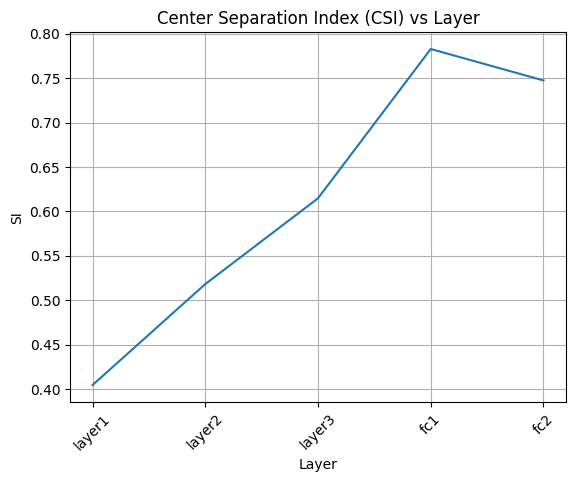

[('layer1', 0.40459999442100525), ('layer2', 0.5181999802589417), ('layer3', 0.614799976348877), ('fc1', 0.7827999591827393), ('fc2', 0.7473999857902527)]


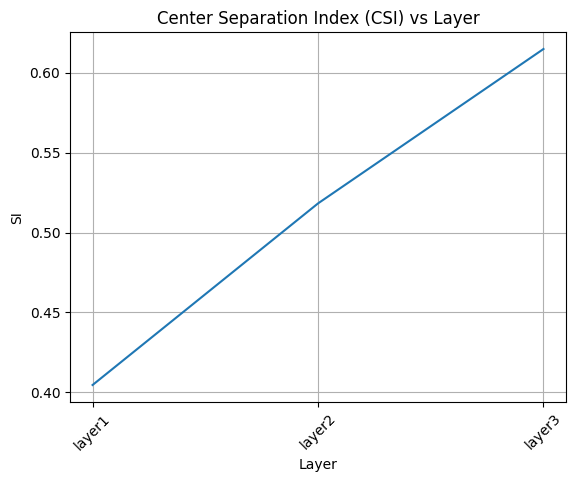

In [18]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_third_layer().to(device)
model.load_state_dict(torch.load('third_layer_ve.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()   

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Fourth Layer

In [19]:
import torch.nn as nn

class VGG11_Fourth_Layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_Fourth_Layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [20]:
import torch
import torch.nn as nn

# Initialize your model
model = VGG11_Fourth_Layer().to(device)

model

VGG11_Fourth_Layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

  7%|▋         | 1/15 [00:23<05:27, 23.38s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.3110, Training Accuracy: 52.67%, Validation Accuracy: 62.94%, Validation Loss: 1.0463


 13%|█▎        | 2/15 [00:45<04:53, 22.60s/it]

Epoch [2/15], Step [352/352], Training Loss: 0.9537, Training Accuracy: 66.17%, Validation Accuracy: 61.84%, Validation Loss: 1.1343


 20%|██        | 3/15 [01:09<04:36, 23.07s/it]

Epoch [3/15], Step [352/352], Training Loss: 0.8194, Training Accuracy: 71.09%, Validation Accuracy: 69.94%, Validation Loss: 0.8491


 27%|██▋       | 4/15 [01:32<04:14, 23.17s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.7309, Training Accuracy: 74.40%, Validation Accuracy: 67.62%, Validation Loss: 0.9542


 33%|███▎      | 5/15 [01:55<03:50, 23.09s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.6551, Training Accuracy: 77.04%, Validation Accuracy: 72.66%, Validation Loss: 0.8043


 40%|████      | 6/15 [02:18<03:26, 22.97s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.4639, Training Accuracy: 84.07%, Validation Accuracy: 80.00%, Validation Loss: 0.5729


 47%|████▋     | 7/15 [02:41<03:04, 23.02s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.4173, Training Accuracy: 85.66%, Validation Accuracy: 80.76%, Validation Loss: 0.5623


 53%|█████▎    | 8/15 [03:04<02:41, 23.11s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.3923, Training Accuracy: 86.56%, Validation Accuracy: 80.88%, Validation Loss: 0.5576


 60%|██████    | 9/15 [03:28<02:19, 23.31s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.3735, Training Accuracy: 87.21%, Validation Accuracy: 81.40%, Validation Loss: 0.5505


 67%|██████▋   | 10/15 [03:51<01:56, 23.20s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.3548, Training Accuracy: 87.83%, Validation Accuracy: 81.54%, Validation Loss: 0.5458


 73%|███████▎  | 11/15 [04:15<01:34, 23.63s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.3237, Training Accuracy: 89.10%, Validation Accuracy: 81.34%, Validation Loss: 0.5611


 80%|████████  | 12/15 [04:39<01:10, 23.66s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.3217, Training Accuracy: 89.25%, Validation Accuracy: 81.86%, Validation Loss: 0.5513


 87%|████████▋ | 13/15 [05:02<00:47, 23.57s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.3193, Training Accuracy: 89.19%, Validation Accuracy: 82.10%, Validation Loss: 0.5641


 93%|█████████▎| 14/15 [05:25<00:23, 23.39s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.3160, Training Accuracy: 89.35%, Validation Accuracy: 81.36%, Validation Loss: 0.5538


100%|██████████| 15/15 [05:47<00:00, 23.19s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.3143, Training Accuracy: 89.52%, Validation Accuracy: 82.20%, Validation Loss: 0.5152


Test Set Accuracy on Best Weights: 82.66%


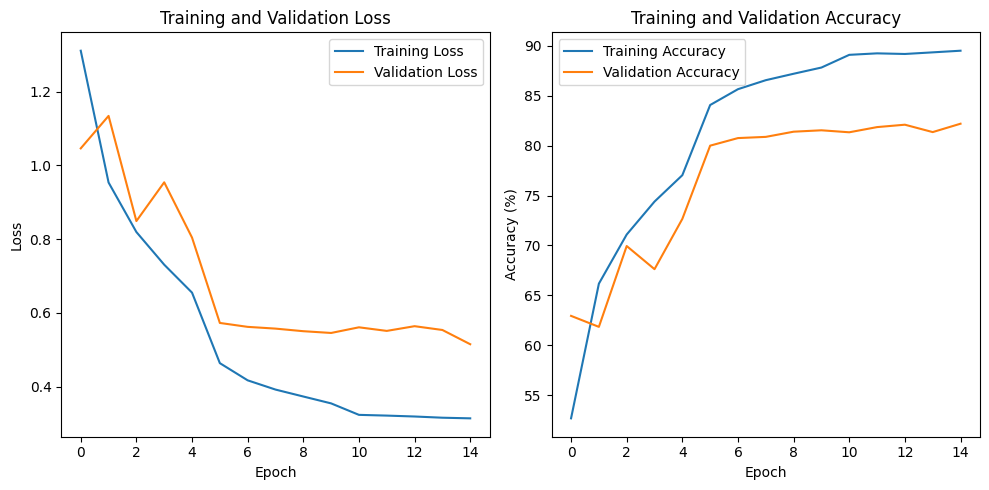

In [15]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0')

# Fourth Layer CSI - train

100%|██████████| 40/40 [00:00<00:00, 41.26it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3142.59it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3237.18it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1999.51it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3026.92it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3073.50it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3515.76it/s]

[('layer1', 0.41279998421669006), ('layer2', 0.49459999799728394), ('layer3', 0.5819999575614929), ('layer4', 0.6589999794960022), ('fc1', 0.8086000084877014), ('fc2', 0.7730000019073486)]


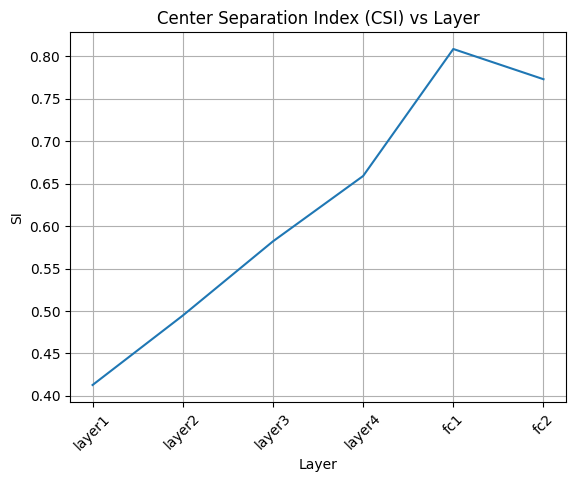

In [21]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_Fourth_Layer().to(device)
model.load_state_dict(torch.load('fourth_layer_ve.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.41279998421669006), ('layer2', 0.49459999799728394), ('layer3', 0.5819999575614929), ('layer4', 0.6589999794960022), ('fc1', 0.8086000084877014), ('fc2', 0.7730000019073486)]


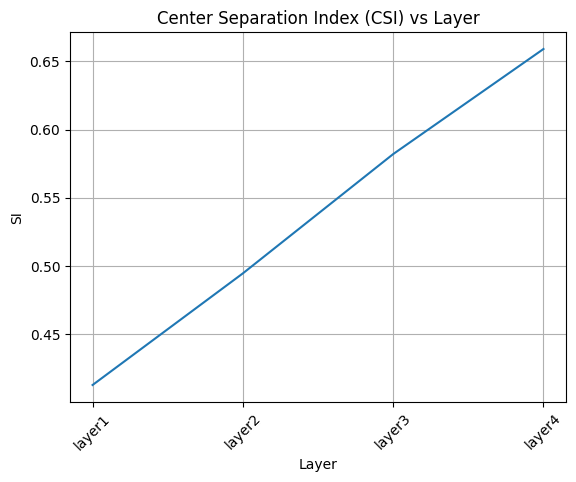

In [22]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Fourth Layer CSI - test

100%|██████████| 79/79 [00:01<00:00, 59.46it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2848.23it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4126.63it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2678.01it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4341.93it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4214.53it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4390.10it/s]

[('layer1', 0.4136999845504761), ('layer2', 0.5023999810218811), ('layer3', 0.5958999991416931), ('layer4', 0.673799991607666), ('fc1', 0.8086000084877014), ('fc2', 0.7799999713897705)]


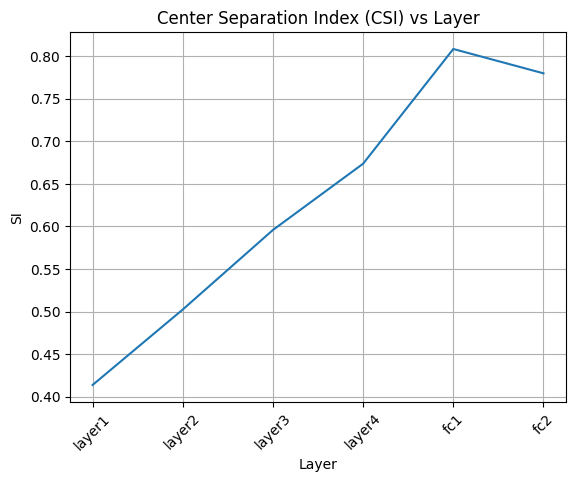

[('layer1', 0.4136999845504761), ('layer2', 0.5023999810218811), ('layer3', 0.5958999991416931), ('layer4', 0.673799991607666), ('fc1', 0.8086000084877014), ('fc2', 0.7799999713897705)]


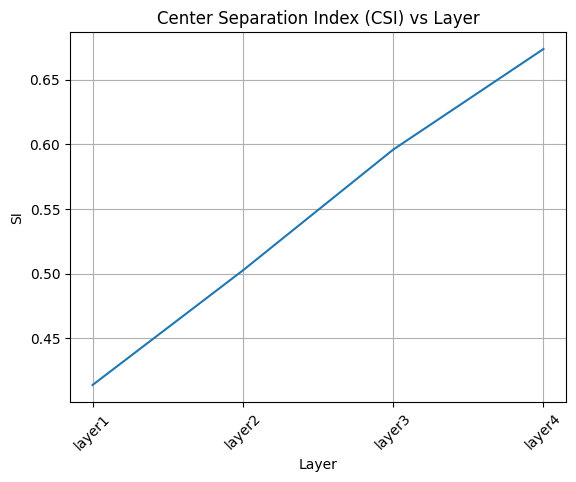

In [23]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_Fourth_Layer().to(device)
model.load_state_dict(torch.load('fourth_layer_ve.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show() 


print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Fifth Layer

In [24]:
import torch.nn as nn

class VGG11_fifth_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_fifth_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(512 * 4 * 4, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [25]:
import torch
import torch.nn as nn


model = VGG11_fifth_layer().to(device)

model

VGG11_fifth_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

  7%|▋         | 1/15 [00:43<10:12, 43.73s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.3124, Training Accuracy: 52.94%, Validation Accuracy: 59.64%, Validation Loss: 1.1507


 13%|█▎        | 2/15 [01:28<09:33, 44.12s/it]

Epoch [2/15], Step [352/352], Training Loss: 0.9277, Training Accuracy: 67.13%, Validation Accuracy: 68.64%, Validation Loss: 0.8877


 20%|██        | 3/15 [02:12<08:50, 44.19s/it]

Epoch [3/15], Step [352/352], Training Loss: 0.7958, Training Accuracy: 72.24%, Validation Accuracy: 67.92%, Validation Loss: 0.9119


 27%|██▋       | 4/15 [02:56<08:05, 44.17s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.7013, Training Accuracy: 75.53%, Validation Accuracy: 74.58%, Validation Loss: 0.7296


 33%|███▎      | 5/15 [03:41<07:24, 44.45s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.6413, Training Accuracy: 77.48%, Validation Accuracy: 74.28%, Validation Loss: 0.7695


 40%|████      | 6/15 [04:25<06:38, 44.29s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.4647, Training Accuracy: 83.85%, Validation Accuracy: 82.22%, Validation Loss: 0.5346


 47%|████▋     | 7/15 [05:09<05:52, 44.07s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.4264, Training Accuracy: 85.25%, Validation Accuracy: 81.82%, Validation Loss: 0.5464


 53%|█████▎    | 8/15 [05:54<05:10, 44.35s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.4041, Training Accuracy: 85.99%, Validation Accuracy: 81.78%, Validation Loss: 0.5293


 60%|██████    | 9/15 [06:37<04:25, 44.21s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.3884, Training Accuracy: 86.54%, Validation Accuracy: 82.56%, Validation Loss: 0.5125


 67%|██████▋   | 10/15 [07:22<03:41, 44.24s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.3723, Training Accuracy: 87.19%, Validation Accuracy: 82.52%, Validation Loss: 0.5252


 73%|███████▎  | 11/15 [08:06<02:57, 44.26s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.3490, Training Accuracy: 87.91%, Validation Accuracy: 82.90%, Validation Loss: 0.4904


 80%|████████  | 12/15 [08:50<02:12, 44.12s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.3421, Training Accuracy: 88.05%, Validation Accuracy: 83.24%, Validation Loss: 0.5008


 87%|████████▋ | 13/15 [09:35<01:28, 44.49s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.3416, Training Accuracy: 88.25%, Validation Accuracy: 83.76%, Validation Loss: 0.4811


 93%|█████████▎| 14/15 [10:19<00:44, 44.39s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.3377, Training Accuracy: 88.53%, Validation Accuracy: 83.10%, Validation Loss: 0.5204


100%|██████████| 15/15 [11:06<00:00, 44.42s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.3369, Training Accuracy: 88.32%, Validation Accuracy: 83.40%, Validation Loss: 0.4786


Test Set Accuracy on Best Weights: 84.26%


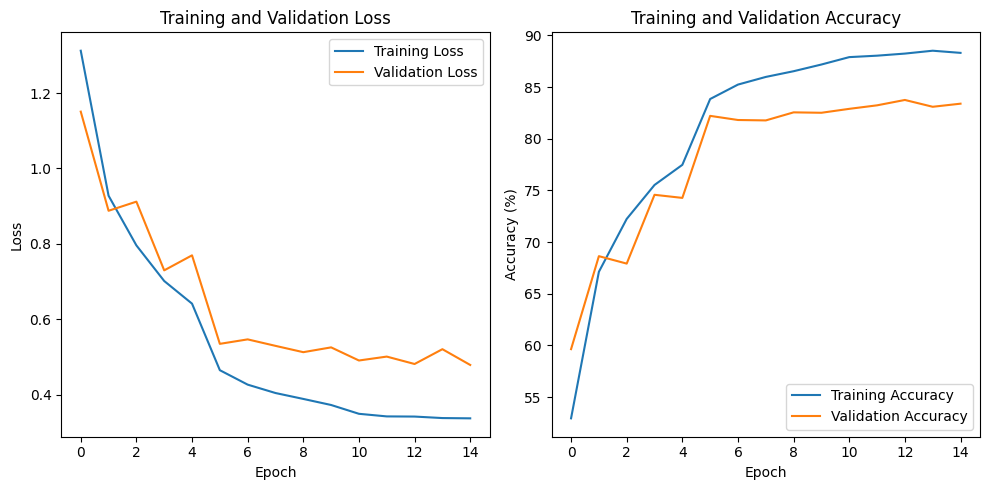

In [18]:
train_and_validate(model, train_loader2, valid_loader2, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0')

# Fifth Layer CSI - train

100%|██████████| 40/40 [00:02<00:00, 18.97it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3105.36it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2926.26it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2000.46it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3158.36it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3003.08it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3113.81it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3450.21it/s]


[('layer1', 0.39980000257492065), ('layer2', 0.4997999966144562), ('layer3', 0.5794000029563904), ('layer4', 0.6394000053405762), ('layer5', 0.7227999567985535), ('fc1', 0.8197999596595764), ('fc2', 0.790399968624115)]


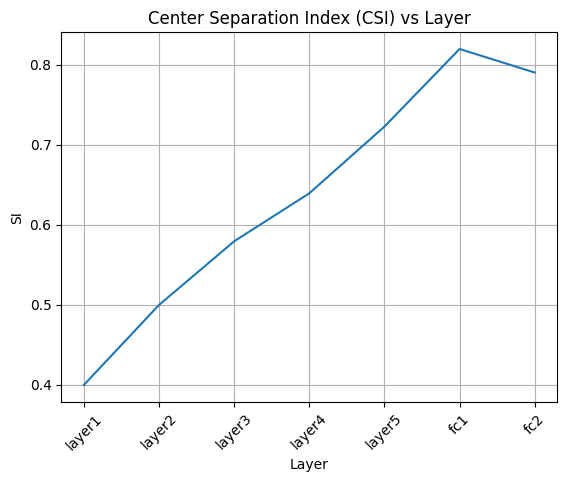

In [26]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_fifth_layer().to(device)
model.load_state_dict(torch.load('fifth_layer_ve.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI2): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.39980000257492065), ('layer2', 0.4997999966144562), ('layer3', 0.5794000029563904), ('layer4', 0.6394000053405762), ('layer5', 0.7227999567985535), ('fc1', 0.8197999596595764), ('fc2', 0.790399968624115)]


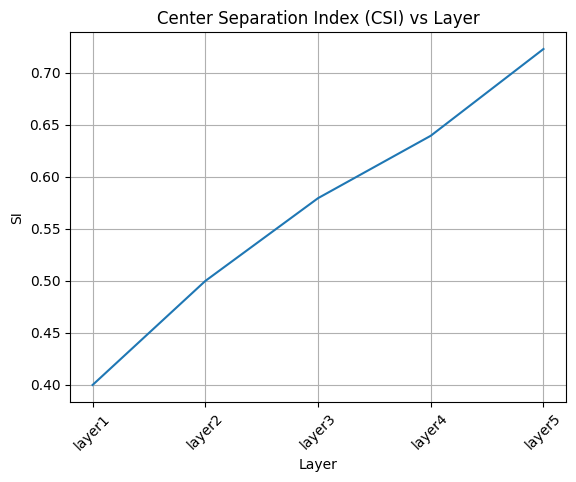

In [27]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Fifth Layer CSI - test

100%|██████████| 79/79 [00:01<00:00, 60.18it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2871.24it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4142.11it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2901.83it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4223.02it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4323.13it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4556.05it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4572.94it/s]

[('layer1', 0.4193999767303467), ('layer2', 0.515500009059906), ('layer3', 0.5947999954223633), ('layer4', 0.6585999727249146), ('layer5', 0.7311999797821045), ('fc1', 0.8287000060081482), ('fc2', 0.8024999499320984)]


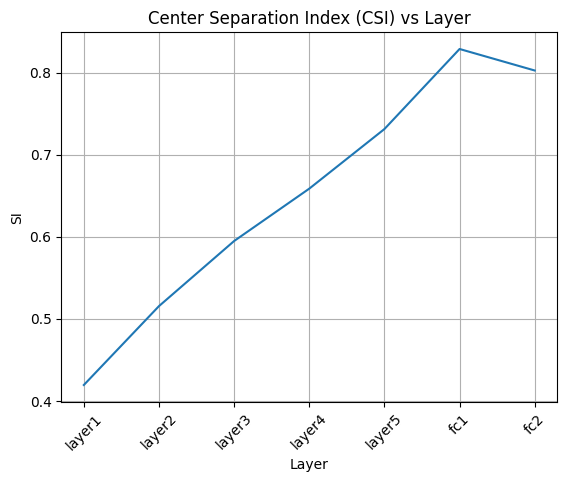

[('layer1', 0.4193999767303467), ('layer2', 0.515500009059906), ('layer3', 0.5947999954223633), ('layer4', 0.6585999727249146), ('layer5', 0.7311999797821045), ('fc1', 0.8287000060081482), ('fc2', 0.8024999499320984)]


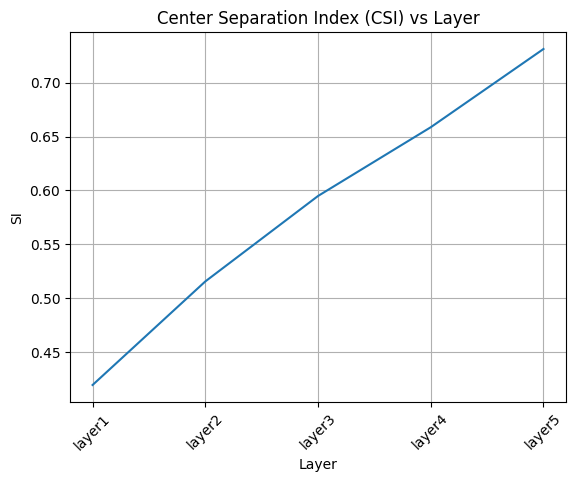

In [28]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_fifth_layer().to(device)
model.load_state_dict(torch.load('fifth_layer_ve.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Sixth Layer

In [29]:
import torch.nn as nn

class VGG11_sixth_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_sixth_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(512 * 2* 2, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [30]:
import torch
import torch.nn as nn

model = VGG11_sixth_layer().to(device)
model

VGG11_sixth_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

  7%|▋         | 1/15 [00:44<10:25, 44.70s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.3255, Training Accuracy: 51.99%, Validation Accuracy: 53.54%, Validation Loss: 1.3387


 13%|█▎        | 2/15 [01:30<09:45, 45.07s/it]

Epoch [2/15], Step [352/352], Training Loss: 0.9458, Training Accuracy: 66.67%, Validation Accuracy: 64.86%, Validation Loss: 0.9913


 20%|██        | 3/15 [02:14<08:59, 44.93s/it]

Epoch [3/15], Step [352/352], Training Loss: 0.7921, Training Accuracy: 72.25%, Validation Accuracy: 68.98%, Validation Loss: 0.8703


 27%|██▋       | 4/15 [02:59<08:12, 44.78s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.6877, Training Accuracy: 76.17%, Validation Accuracy: 73.72%, Validation Loss: 0.7734


 33%|███▎      | 5/15 [03:44<07:29, 44.98s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.6236, Training Accuracy: 78.34%, Validation Accuracy: 75.78%, Validation Loss: 0.7356


 40%|████      | 6/15 [04:29<06:43, 44.87s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.4449, Training Accuracy: 84.64%, Validation Accuracy: 82.02%, Validation Loss: 0.5358


 47%|████▋     | 7/15 [05:15<06:01, 45.16s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.4022, Training Accuracy: 86.04%, Validation Accuracy: 82.32%, Validation Loss: 0.4923


 53%|█████▎    | 8/15 [05:59<05:15, 45.03s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.3798, Training Accuracy: 86.87%, Validation Accuracy: 82.64%, Validation Loss: 0.4994


 60%|██████    | 9/15 [06:44<04:28, 44.81s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.3631, Training Accuracy: 87.30%, Validation Accuracy: 83.54%, Validation Loss: 0.4972


 67%|██████▋   | 10/15 [07:29<03:45, 45.04s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.3432, Training Accuracy: 88.07%, Validation Accuracy: 82.94%, Validation Loss: 0.4836


 73%|███████▎  | 11/15 [08:14<02:59, 44.88s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.3168, Training Accuracy: 89.10%, Validation Accuracy: 83.02%, Validation Loss: 0.4846


 80%|████████  | 12/15 [08:59<02:14, 44.97s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.3120, Training Accuracy: 89.18%, Validation Accuracy: 83.12%, Validation Loss: 0.4930


 87%|████████▋ | 13/15 [09:44<01:29, 44.90s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.3100, Training Accuracy: 89.27%, Validation Accuracy: 83.58%, Validation Loss: 0.4902


 93%|█████████▎| 14/15 [10:29<00:44, 44.93s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.3066, Training Accuracy: 89.38%, Validation Accuracy: 83.94%, Validation Loss: 0.4635


100%|██████████| 15/15 [11:14<00:00, 44.94s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.3035, Training Accuracy: 89.61%, Validation Accuracy: 83.68%, Validation Loss: 0.4766


Test Set Accuracy on Best Weights: 85.40%


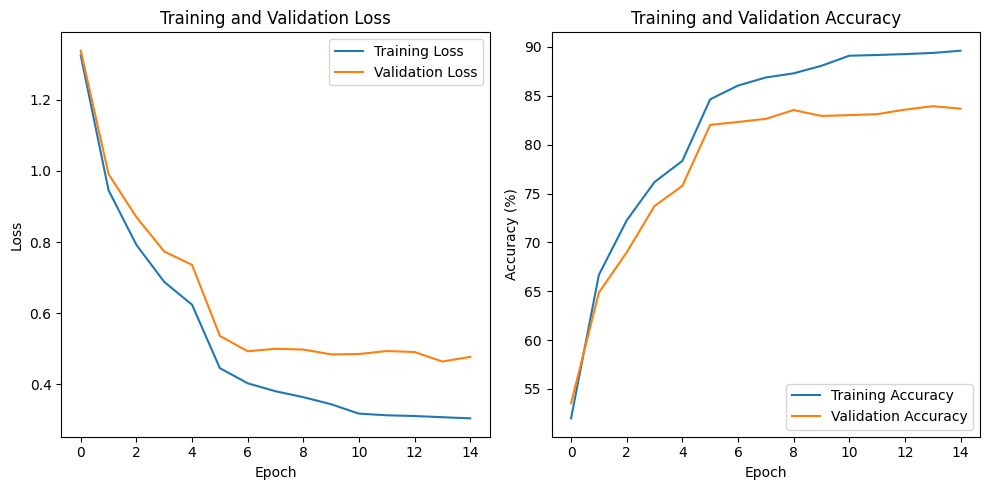

In [21]:
train_and_validate(model, train_loader2, valid_loader2, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0')

# Sixth Layer CSI - train

100%|██████████| 40/40 [00:02<00:00, 18.38it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3005.95it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3149.67it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1971.93it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3337.64it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3082.54it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2992.37it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2989.53it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3360.82it/s]

[('layer1', 0.40139999985694885), ('layer2', 0.5001999735832214), ('layer3', 0.5673999786376953), ('layer4', 0.6279999613761902), ('layer5', 0.7015999555587769), ('layer6', 0.7745999693870544), ('fc1', 0.8227999806404114), ('fc2', 0.7973999977111816)]


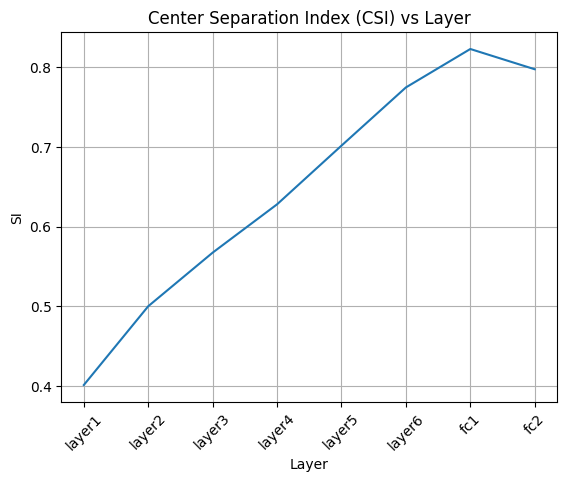

In [31]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_sixth_layer().to(device)
model.load_state_dict(torch.load('sixth_layer_ve.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI2): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.40139999985694885), ('layer2', 0.5001999735832214), ('layer3', 0.5673999786376953), ('layer4', 0.6279999613761902), ('layer5', 0.7015999555587769), ('layer6', 0.7745999693870544), ('fc1', 0.8227999806404114), ('fc2', 0.7973999977111816)]


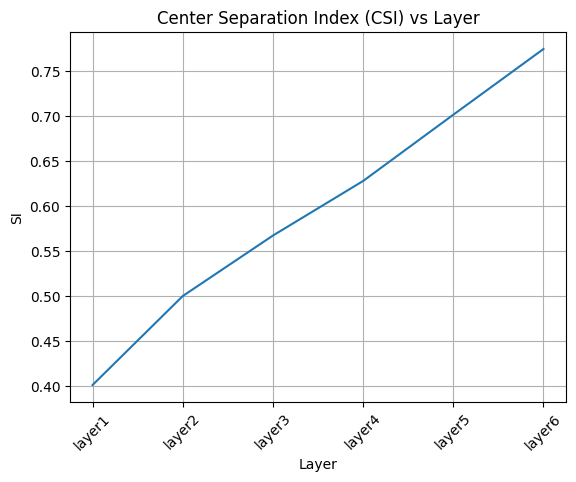

In [32]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Sixth Layer CSI - test

100%|██████████| 79/79 [00:01<00:00, 51.23it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2770.71it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3988.50it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2689.35it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4087.22it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4391.94it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4334.75it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4268.58it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4306.27it/s]


[('layer1', 0.4193999767303467), ('layer2', 0.5112999677658081), ('layer3', 0.582099974155426), ('layer4', 0.6502000093460083), ('layer5', 0.7198999524116516), ('layer6', 0.7888999581336975), ('fc1', 0.836899995803833), ('fc2', 0.8144999742507935)]


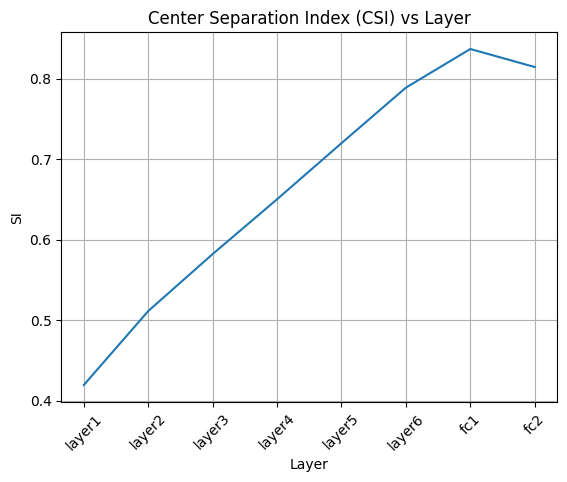

In [33]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_sixth_layer().to(device)
model.load_state_dict(torch.load('sixth_layer_ve.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.4193999767303467), ('layer2', 0.5112999677658081), ('layer3', 0.582099974155426), ('layer4', 0.6502000093460083), ('layer5', 0.7198999524116516), ('layer6', 0.7888999581336975), ('fc1', 0.836899995803833), ('fc2', 0.8144999742507935)]


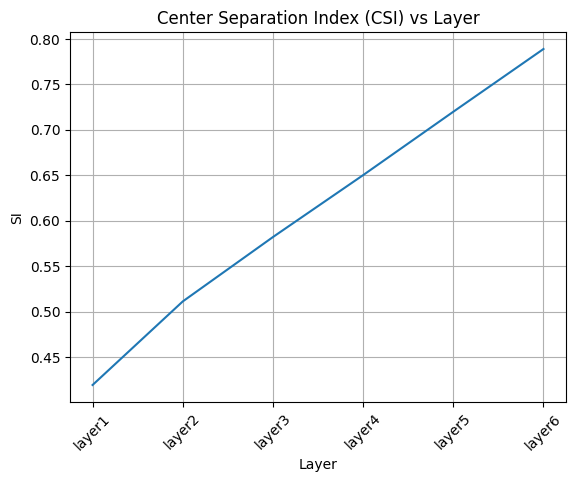

In [34]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# seventh Layer

In [35]:
import torch.nn as nn

class VGG11_seven_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_seven_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(512 * 2 * 2, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [36]:
import torch
import torch.nn as nn

model = VGG11_seven_layer().to(device)

model

VGG11_seven_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

  7%|▋         | 1/15 [00:45<10:30, 45.07s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.2906, Training Accuracy: 53.31%, Validation Accuracy: 60.66%, Validation Loss: 1.1268


 13%|█▎        | 2/15 [01:29<09:43, 44.87s/it]

Epoch [2/15], Step [352/352], Training Loss: 0.9111, Training Accuracy: 67.74%, Validation Accuracy: 67.28%, Validation Loss: 0.9516


 20%|██        | 3/15 [02:15<09:05, 45.46s/it]

Epoch [3/15], Step [352/352], Training Loss: 0.7602, Training Accuracy: 73.61%, Validation Accuracy: 72.12%, Validation Loss: 0.7851


 27%|██▋       | 4/15 [03:01<08:18, 45.30s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.6665, Training Accuracy: 76.75%, Validation Accuracy: 73.94%, Validation Loss: 0.7208


 33%|███▎      | 5/15 [03:47<07:38, 45.82s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.6042, Training Accuracy: 78.78%, Validation Accuracy: 77.22%, Validation Loss: 0.6802


 40%|████      | 6/15 [04:32<06:50, 45.56s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.4306, Training Accuracy: 85.09%, Validation Accuracy: 82.48%, Validation Loss: 0.4961


 47%|████▋     | 7/15 [05:19<06:06, 45.83s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.3849, Training Accuracy: 86.63%, Validation Accuracy: 82.60%, Validation Loss: 0.5073


 53%|█████▎    | 8/15 [06:04<05:19, 45.64s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.3624, Training Accuracy: 87.53%, Validation Accuracy: 82.92%, Validation Loss: 0.4938


 60%|██████    | 9/15 [06:50<04:35, 45.85s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.3462, Training Accuracy: 87.90%, Validation Accuracy: 83.22%, Validation Loss: 0.4849


 67%|██████▋   | 10/15 [07:35<03:48, 45.66s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.3233, Training Accuracy: 88.79%, Validation Accuracy: 83.70%, Validation Loss: 0.5070


 73%|███████▎  | 11/15 [08:22<03:03, 45.87s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.2941, Training Accuracy: 89.80%, Validation Accuracy: 83.68%, Validation Loss: 0.4780


 80%|████████  | 12/15 [09:07<02:16, 45.66s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.2861, Training Accuracy: 90.28%, Validation Accuracy: 84.16%, Validation Loss: 0.4651


 87%|████████▋ | 13/15 [09:53<01:31, 45.81s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.2846, Training Accuracy: 90.40%, Validation Accuracy: 83.54%, Validation Loss: 0.4728


 93%|█████████▎| 14/15 [10:39<00:45, 45.69s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.2803, Training Accuracy: 90.41%, Validation Accuracy: 83.60%, Validation Loss: 0.4756


100%|██████████| 15/15 [11:24<00:00, 45.65s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.2777, Training Accuracy: 90.53%, Validation Accuracy: 83.76%, Validation Loss: 0.4856


Test Set Accuracy on Best Weights: 85.50%


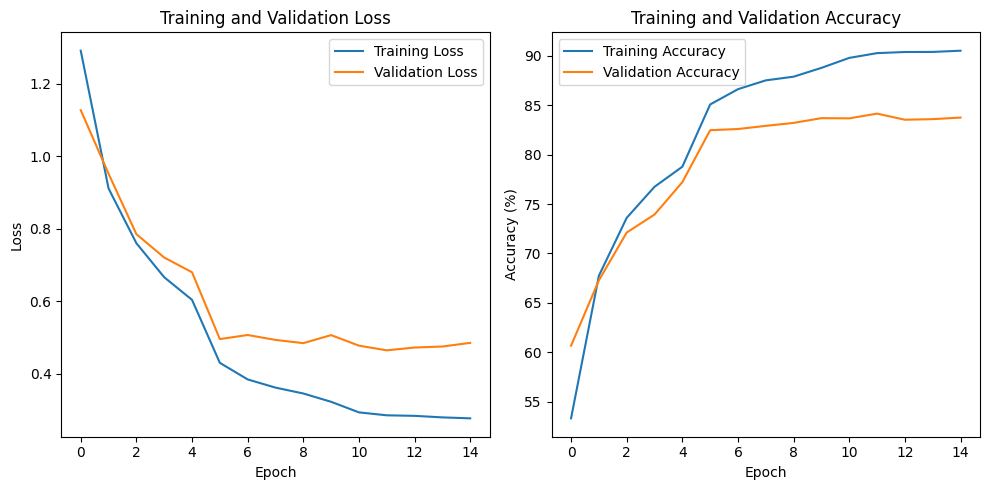

In [24]:
train_and_validate(model, train_loader2, valid_loader2, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0')

# Seventh Layer CSI - train

100%|██████████| 40/40 [00:02<00:00, 18.68it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2940.62it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3056.33it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1971.32it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2715.93it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3378.87it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3171.90it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2832.71it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2866.27it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3139.45it/s]

[('layer1', 0.40219998359680176), ('layer2', 0.49779999256134033), ('layer3', 0.5758000016212463), ('layer4', 0.6347999572753906), ('layer5', 0.7008000016212463), ('layer6', 0.7841999530792236), ('layer7', 0.8281999826431274), ('fc1', 0.839199960231781), ('fc2', 0.8191999793052673)]


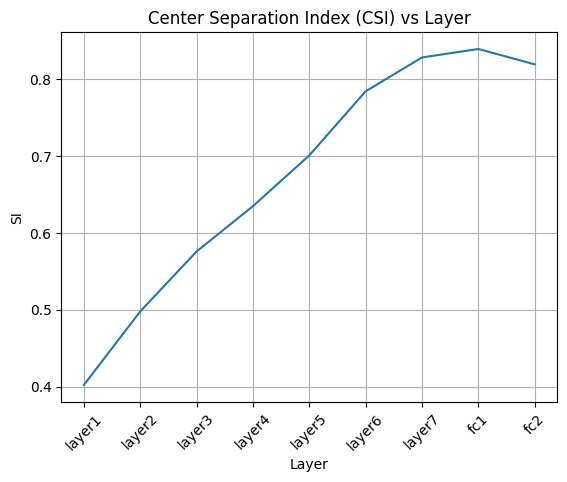

[('layer1', 0.40219998359680176), ('layer2', 0.49779999256134033), ('layer3', 0.5758000016212463), ('layer4', 0.6347999572753906), ('layer5', 0.7008000016212463), ('layer6', 0.7841999530792236), ('layer7', 0.8281999826431274), ('fc1', 0.839199960231781), ('fc2', 0.8191999793052673)]


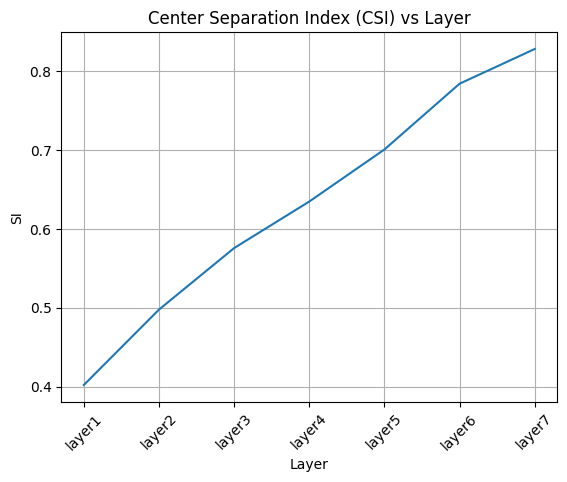

In [37]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_seven_layer().to(device)
model.load_state_dict(torch.load('seventh_layer_ve.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI2): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    


print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Seventh Layer CSI - test

100%|██████████| 79/79 [00:01<00:00, 59.43it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3019.66it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4105.62it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2830.55it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4159.37it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4175.10it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4137.21it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4522.65it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4477.27it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4336.54it/s]

[('layer1', 0.41999998688697815), ('layer2', 0.5162999629974365), ('layer3', 0.5880999565124512), ('layer4', 0.6538000106811523), ('layer5', 0.7123000025749207), ('layer6', 0.7945999503135681), ('layer7', 0.8359999656677246), ('fc1', 0.8452000021934509), ('fc2', 0.8298999667167664)]


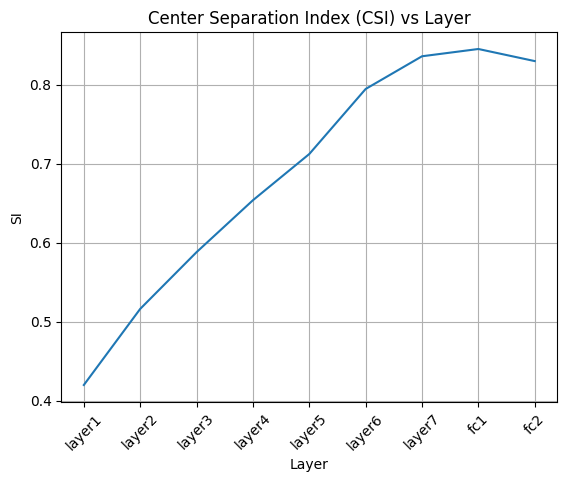

[('layer1', 0.41999998688697815), ('layer2', 0.5162999629974365), ('layer3', 0.5880999565124512), ('layer4', 0.6538000106811523), ('layer5', 0.7123000025749207), ('layer6', 0.7945999503135681), ('layer7', 0.8359999656677246), ('fc1', 0.8452000021934509), ('fc2', 0.8298999667167664)]


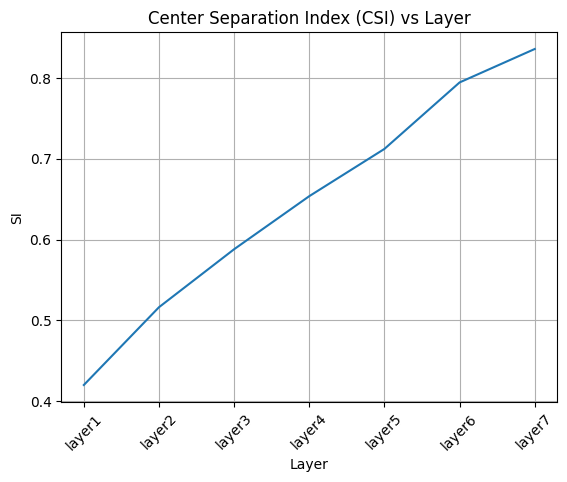

In [38]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_seven_layer().to(device)
model.load_state_dict(torch.load('seventh_layer_ve.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    


print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Eighth Layer

In [39]:
import torch.nn as nn

class VGG11_eighth_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_eighth_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(512, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [40]:
import torch
import torch.nn as nn


model = VGG11_eighth_layer().to(device)

model

VGG11_eighth_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

  7%|▋         | 1/15 [00:46<10:55, 46.85s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.3558, Training Accuracy: 50.39%, Validation Accuracy: 58.76%, Validation Loss: 1.1180


 13%|█▎        | 2/15 [01:32<10:03, 46.41s/it]

Epoch [2/15], Step [352/352], Training Loss: 0.9563, Training Accuracy: 66.26%, Validation Accuracy: 64.60%, Validation Loss: 1.0447


 20%|██        | 3/15 [02:19<09:16, 46.38s/it]

Epoch [3/15], Step [352/352], Training Loss: 0.8056, Training Accuracy: 71.89%, Validation Accuracy: 71.14%, Validation Loss: 0.8047


 27%|██▋       | 4/15 [03:05<08:31, 46.48s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.6994, Training Accuracy: 75.79%, Validation Accuracy: 74.86%, Validation Loss: 0.7449


 33%|███▎      | 5/15 [03:52<07:43, 46.40s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.6301, Training Accuracy: 78.10%, Validation Accuracy: 74.02%, Validation Loss: 0.7959


 40%|████      | 6/15 [04:38<06:56, 46.28s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.4620, Training Accuracy: 84.04%, Validation Accuracy: 82.14%, Validation Loss: 0.5123


 47%|████▋     | 7/15 [05:24<06:11, 46.41s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.4080, Training Accuracy: 85.81%, Validation Accuracy: 82.72%, Validation Loss: 0.5099


 53%|█████▎    | 8/15 [06:11<05:24, 46.32s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.3789, Training Accuracy: 86.94%, Validation Accuracy: 82.62%, Validation Loss: 0.5153


 60%|██████    | 9/15 [06:57<04:37, 46.33s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.3583, Training Accuracy: 87.61%, Validation Accuracy: 82.88%, Validation Loss: 0.5126


 67%|██████▋   | 10/15 [07:43<03:51, 46.22s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.3377, Training Accuracy: 88.40%, Validation Accuracy: 82.60%, Validation Loss: 0.4898


 73%|███████▎  | 11/15 [08:29<03:04, 46.13s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.3062, Training Accuracy: 89.55%, Validation Accuracy: 83.76%, Validation Loss: 0.4771


 80%|████████  | 12/15 [09:15<02:18, 46.08s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.2980, Training Accuracy: 89.68%, Validation Accuracy: 83.60%, Validation Loss: 0.5006


 87%|████████▋ | 13/15 [10:01<01:32, 46.13s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.2956, Training Accuracy: 89.76%, Validation Accuracy: 84.20%, Validation Loss: 0.4804


 93%|█████████▎| 14/15 [10:47<00:45, 45.98s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.2942, Training Accuracy: 89.89%, Validation Accuracy: 84.58%, Validation Loss: 0.4854


100%|██████████| 15/15 [11:33<00:00, 46.23s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.2878, Training Accuracy: 90.10%, Validation Accuracy: 83.80%, Validation Loss: 0.4858


Test Set Accuracy on Best Weights: 84.67%


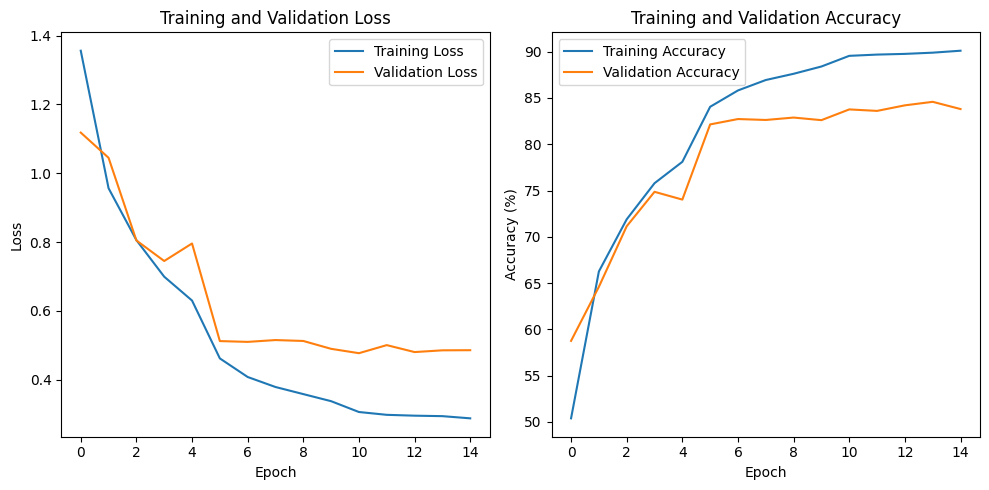

In [27]:
train_and_validate(model, train_loader2, valid_loader2, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0')

# Eighth Layer CSI - train

100%|██████████| 40/40 [00:02<00:00, 17.48it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1946.31it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3196.07it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2066.84it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3196.07it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2989.53it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3257.29it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3081.78it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3298.27it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3051.88it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3264.90it/s]

[('layer1', 0.3905999958515167), ('layer2', 0.4893999993801117), ('layer3', 0.5633999705314636), ('layer4', 0.6319999694824219), ('layer5', 0.6965999603271484), ('layer6', 0.776199996471405), ('layer7', 0.8241999745368958), ('layer8', 0.8265999555587769), ('fc1', 0.8321999907493591), ('fc2', 0.8259999752044678)]


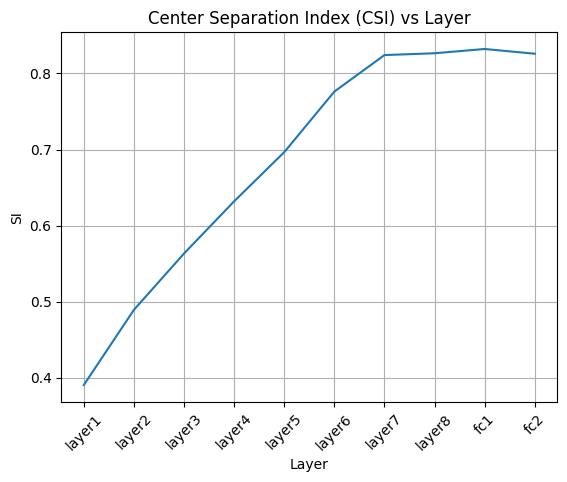

In [41]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_eighth_layer().to(device)
model.load_state_dict(torch.load('eighth_layer_ve.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI2): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.3905999958515167), ('layer2', 0.4893999993801117), ('layer3', 0.5633999705314636), ('layer4', 0.6319999694824219), ('layer5', 0.6965999603271484), ('layer6', 0.776199996471405), ('layer7', 0.8241999745368958), ('layer8', 0.8265999555587769), ('fc1', 0.8321999907493591), ('fc2', 0.8259999752044678)]


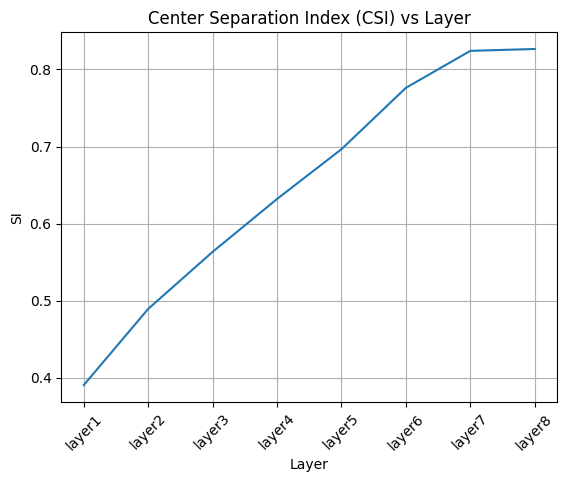

In [42]:
print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Eighth Layer CSI - test

100%|██████████| 79/79 [00:01<00:00, 58.42it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2720.75it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4151.95it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2955.82it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4006.02it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4617.24it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4117.71it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4243.53it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4462.98it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4467.73it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4430.91it/s]

[('layer1', 0.4139999747276306), ('layer2', 0.5084999799728394), ('layer3', 0.5781999826431274), ('layer4', 0.6446999907493591), ('layer5', 0.7080999612808228), ('layer6', 0.7810999751091003), ('layer7', 0.8287999629974365), ('layer8', 0.8355000019073486), ('fc1', 0.842199981212616), ('fc2', 0.8317999839782715)]


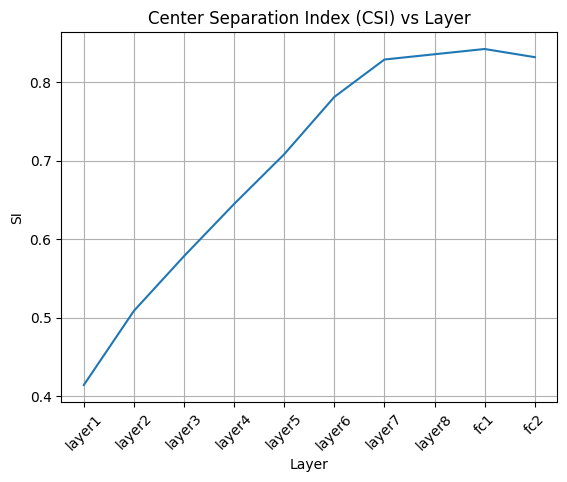

[('layer1', 0.4139999747276306), ('layer2', 0.5084999799728394), ('layer3', 0.5781999826431274), ('layer4', 0.6446999907493591), ('layer5', 0.7080999612808228), ('layer6', 0.7810999751091003), ('layer7', 0.8287999629974365), ('layer8', 0.8355000019073486), ('fc1', 0.842199981212616), ('fc2', 0.8317999839782715)]


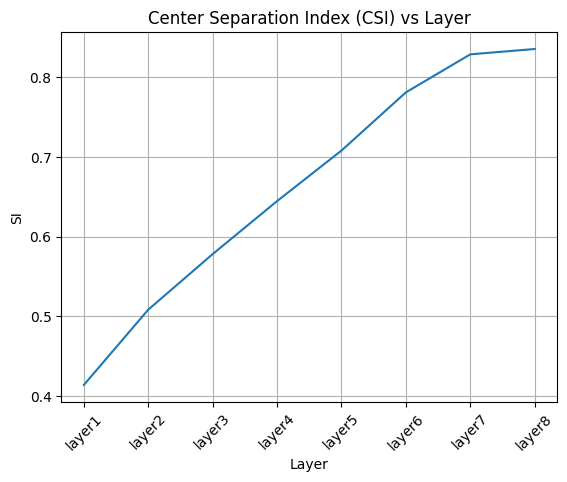

In [43]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_eighth_layer().to(device)
model.load_state_dict(torch.load('eighth_layer_ve.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show() 

print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()